In [13]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import argparse
import os

# Argument parser
# parser = argparse.ArgumentParser()
# parser.add_argument('--id', type=str,                   default='', help='Unique experiment identifier')
# parser.add_argument('--N', type=int,                    default=128, help='Number of antennas.')
# parser.add_argument('--generate_dataset', type=int,     default=0, help='Generate Dataset.')
# parser.add_argument('--logdir', type=str,               default='saved_models', help='Directory to log data to')
# args = parser.parse_args()

#---------- SIMULATION PARAMETERS -----------
f0 = 25e9                   # carrier frequency
k = 2*np.pi / (3e8 / f0)    # wave number
c = 3e8
wavelength = c / f0         # Wavelength
d = wavelength / 2          # Antenna spacing
N = 128                  # Number of antennas
SNR_dB = list(range(0, 25, 5))
SNR = [10 ** (SNR / 10) for SNR in SNR_dB]

array_length = d*(N-1)
near_field_boundary = 2*array_length**2/wavelength
print(f'Near-field up to {near_field_boundary:.1f} m')
# angle_true = float(input("Enter the true angle (in degrees): "))
# r_true = float(input("Enter the true range (in meters): "))
angle_true, r_true = -20, 5
theta_true = np.radians(angle_true)  # True angle
theta = np.sin(theta_true)

range_limits = [1,20]

rng_seed = 42
np.random.seed(rng_seed)

def CN_realization(mean, std_dev, size=1):
    return np.random.normal(mean, std_dev, size) + 1j * np.random.normal(mean, std_dev, size)

# Steering vector dependent only on the angle
delta = lambda n: (2 * n - N + 1) / 2
a_far = lambda theta: np.exp(-1j * k * delta(np.arange(N)) * d * theta)
# a = lambda theta, r: np.array([np.exp(-1j*k*(np.sqrt(r**2 + delta(n)**2*d**2 - 2*r*theta*delta(n)*d) - r)) for n in range(N)]).T
a = lambda theta, r: np.array(np.exp(-1j*k*(np.sqrt(r**2 + delta(np.arange(N))**2*d**2 - 2*r*theta*delta(np.arange(N))*d) - r))).T
a_n = lambda theta, r, n: np.exp(-1j*k*(np.sqrt(r**2 + delta(n)**2*d**2 - 2*r*theta*delta(n)*d) - r))

# partial derivatives of the steering vector a(theta,r) in vectorial form
da_dtheta = lambda theta, r: np.array([a_n(theta,r,n)*1j*k*delta(n)*d/np.sqrt(r**2 + delta(n)**2*d**2 - 2*r*theta*delta(n)*d) for n in range(N)]).T
# da_dr1 = lambda theta, r: np.array([-1j*k*a_n(theta,r,n)*((r-theta*delta(n)*d)/np.sqrt(r**2 + delta(n)**2*d**2 - 2*r*theta*delta(n)*d) - 1) for n in range(N)]).T
da_dr = lambda theta, r: np.array(-1j*k*a(theta,r)*((r-theta*delta(np.arange(N))*d)/np.sqrt(r**2 + delta(np.arange(N))**2*d**2 - 2*r*theta*delta(np.arange(N))*d) - 1)).T
def derivative_theta(theta, r, h=1e-5):
    return (a(theta + h, r) - a(theta - h, r)) / (2 * h)

def derivative_r(theta, r, h=1e-5):
    return (a(theta, r + h) - a(theta, r - h)) / (2 * h)

snr = SNR[-1]  # 20 dB
sigma_s = 1.
sigma_n = sigma_s / np.sqrt(snr)

s = CN_realization(mean=0, std_dev=sigma_s)
n = CN_realization(mean=0, std_dev=sigma_n, size=N)

# y = a(theta) * s + n  # Far-field signal
y = a(theta, r_true) * s + n  # Near-field signal
y = y.reshape((N,1))

Near-field up to 96.8 m


visualize the scatterer position

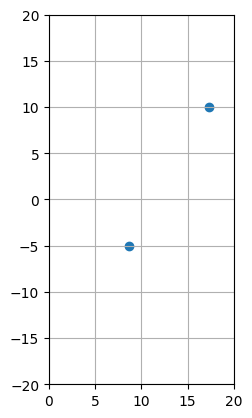

-0.5 10 0.5 20


In [46]:
theta = -.5
r = 10
theta_scat = 0.5
r_scat = 20

def pol2cart(theta,r):
    return np.stack((r*np.sqrt(1-theta**2),r*theta),axis=-1)

p = pol2cart(theta,r)
p_scat = pol2cart(theta_scat,r_scat)
plt.scatter([p[0], p_scat[0]],[p[1], p_scat[1]])
plt.axis('scaled')
plt.xlim([0,20])
plt.ylim([-20,20])
plt.grid()
plt.show()
print(theta,r,theta_scat,r_scat)

Now that we have generated the received signal at the XL-MIMO array from the single source, we can estimate the CRLB of the range and angle paramenters.

<img src="./imgs/notebook_py/CRLB.png" width="850">
<img src="./imgs/notebook_py/CRLB1.png" width="500">

In [46]:
# da_dtheta_1 = da_dtheta(theta_true,r_true)
# da_dr_1 = da_dr(theta_true,r_true)
da_dtheta_ = derivative_theta(theta,r_true)
da_dr_ = derivative_r(theta,r_true)

P = sigma_s
J = np.ones((2,2),dtype=float)
D = np.c_[da_dtheta_,da_dr_] # shape=(N,2)
A = a(theta,r_true).reshape((N,1))
H = np.eye(N) - A@np.linalg.pinv(A)
R = np.dot(y, y.T.conj()) / y.shape[0]

D_H_D = D.conj().T@H@D
PARAP = A.conj().T@np.linalg.inv(R)@A * P
FIM = np.real(D_H_D )#* (np.kron(J,PARAP.T))
CRB = 1/2*sigma_n**2 * np.linalg.inv(FIM)
# print(D_H_D,'\n\n',np.kron(J,PARAP.T))
CRB

array([[2.92121043e-07, 6.17706424e-06],
       [6.17706424e-06, 2.37453702e-02]])

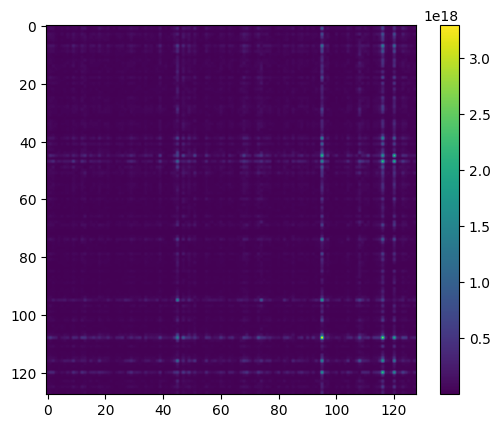

In [40]:
angle_true, r_true = -45, 10
theta_true = np.radians(angle_true)  # True angle
theta = np.sin(theta_true)
snr = SNR[0]  # 20 dB
sigma_s = 1
sigma_n = sigma_s / np.sqrt(snr)
s = CN_realization(mean=0, std_dev=sigma_s)
n = CN_realization(mean=0, std_dev=sigma_n, size=N)
y = a(theta, r_true) * s + n  # Near-field signal
y = y.reshape((N,1))

A = a(theta,r_true).reshape((N,1))
R = np.dot(y, y.T.conj()) / y.shape[0]

R_inv = np.linalg.inv(R)
PARAP = A.conj().T@R_inv@A * P

plt.imshow(np.abs(R_inv))
plt.colorbar()


c:\Users\Mattia\anaconda3\envs\beamwise\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


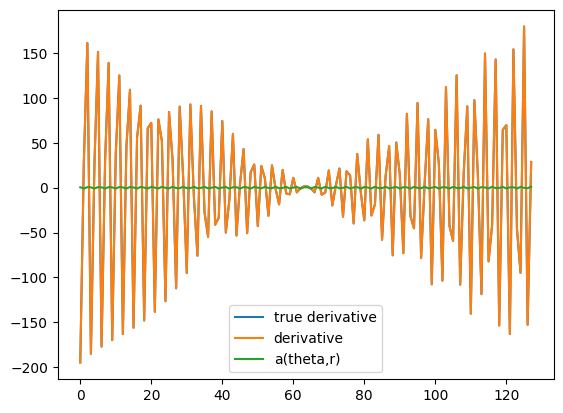

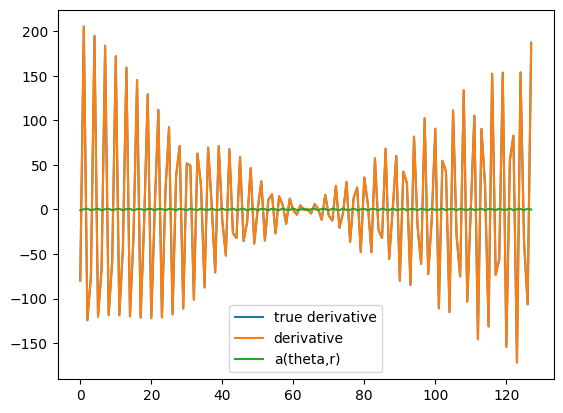

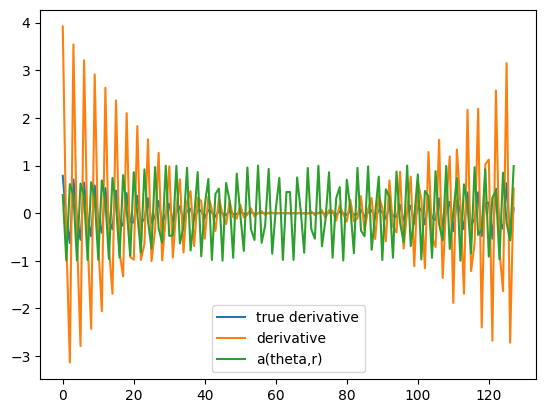

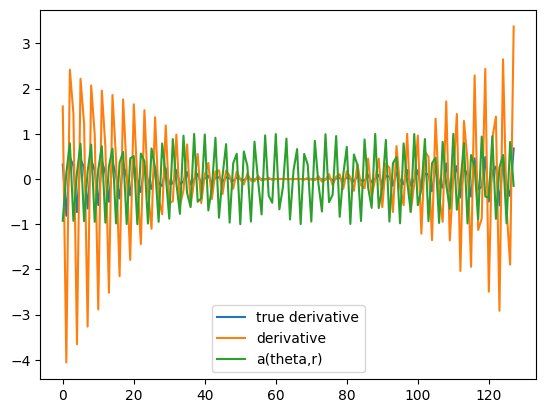

In [41]:
angle_true, r_true = -45, 5
theta_true = np.radians(angle_true)  # True angle
theta = np.sin(theta_true)

da_dtheta_1 = da_dtheta(theta,r_true)*5
da_dr_1 = da_dr(theta,r_true)*5
da_dtheta_ = derivative_theta(theta,r_true)
da_dr_ = derivative_r(theta,r_true)

plt.plot(da_dtheta_,label='true derivative')
plt.plot(da_dtheta_1,label='derivative')
plt.plot(a(theta,r_true),label='a(theta,r)')
plt.legend()

plt.figure()
plt.plot(np.imag(da_dtheta_),label='true derivative')
plt.plot(np.imag(da_dtheta_1),label='derivative')
plt.plot(np.imag(a(theta,r_true)),label='a(theta,r)')
plt.legend()

plt.figure()
plt.plot(da_dr_,label='true derivative')
plt.plot(da_dr_1,label='derivative')
plt.plot(a(theta,r_true),label='a(theta,r)')
plt.legend()

plt.figure()
plt.plot(np.imag(da_dr_),label='true derivative')
plt.plot(np.imag(da_dr_1),label='derivative')
plt.plot(np.imag(a(theta,r_true)),label='a(theta,r)')
plt.legend()

In [199]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

# fix the seed for reproducibility
rng_seed = 42
np.random.seed(rng_seed)

#---------- SIMULATION PARAMETERS -----------
f0 = 25e9                   # carrier frequency
k = 2*np.pi / (3e8 / f0)    # wave number
c = 3e8                     # speed of light
wavelength = c / f0         # Wavelength
d = wavelength / 2          # Antenna spacing
N = 128                     # Number of antennas
range_limits = [1,10]       # range limits
N_ang, N_r = 180, 100        # ML grid
ch_realizations = 2000       # channel realizations (for CRLB and ML)
SNR_dB = list(range(0, 25, 5)) # SNR_dB
SNR = [10 ** (SNR / 10) for SNR in SNR_dB]

## Near-field boundary [m]
array_length = d*(N-1)
near_field_boundary = 2*array_length**2/wavelength
print(f'Near-field up to {near_field_boundary:.1f} m')


def CN_realization(mean, std_dev, size=1):
    return np.random.normal(mean, std_dev, size) + 1j * np.random.normal(mean, std_dev, size)

# Steering vector dependent only on the angle
delta = lambda n: (2 * n - N + 1) / 2
a = lambda theta, r: np.array(np.exp(-1j*k*(np.sqrt(r**2 + delta(np.arange(N))**2*d**2 - 2*r*theta*delta(np.arange(N))*d) - r))).T
def derivative_theta(theta, r, h=1e-5):
    return (a(theta + h, r) - a(theta - h, r)) / (2 * h)
def derivative_r(theta, r, h=1e-5):
    return (a(theta, r + h) - a(theta, r - h)) / (2 * h)



## CRLB init
# P = sigma_s
J = np.ones((2,2),dtype=float)
CRB = np.zeros((len(SNR),ch_realizations,2,2),dtype=float)

## maximum likelihood init
ang_grid = np.linspace(-np.pi/2, np.pi/2, N_ang)  # Angle grid in radians
range_grid = np.linspace(range_limits[0], range_limits[1], N_r)  # Range grid in meters
rmse_angle_deg = np.zeros((len(SNR),ch_realizations),dtype=float)
rmse_angle_sin = np.zeros((len(SNR),ch_realizations),dtype=float)
rmse_r = np.zeros((len(SNR),ch_realizations),dtype=float)
pts = np.zeros((len(SNR),ch_realizations,2),dtype=float)
    
dataset_crlb = dict()
ii = 0
print(f'total iterations: {len(SNR)*ch_realizations}')
for idx_snr, snr in enumerate(SNR):
    sigma_n = 1 / np.sqrt(snr)
    print(f'{idx_snr+1}/{len(SNR)}, SNR = {SNR_dB[idx_snr]} dB')
    for i in tqdm(range(ch_realizations)):
        s = CN_realization(mean=0, std_dev=1)
        n = CN_realization(mean=0, std_dev=sigma_n, size=N)
        
        r = np.random.uniform(range_limits[0], range_limits[1])
        r_norm = 2 * (r - range_limits[0]) / (range_limits[1] - range_limits[0]) - 1
        theta = np.random.uniform(-1,1)
        pts[idx_snr,i,:] = np.stack([np.arcsin(theta),r])
        
        # uplink received signal
        y_ = a(theta,r) * s + n
        y = y_.reshape((N,1))

        da_dtheta_ = derivative_theta(theta,r)
        da_dr_ = derivative_r(theta,r)

        A = a(theta,r).reshape((N,1))
        H = np.eye(N) - A@np.linalg.pinv(A)
        D = np.c_[da_dtheta_,da_dr_] # shape=(N,2)
        R = np.dot(y, y.T.conj()) / y.shape[0]

        D_H_D = D.conj().T@H@D
        # PARAP = A.conj().T@np.linalg.inv(R)@A * P
        FIM = np.real(D_H_D )#* (np.kron(J,PARAP.T))
        CRB[idx_snr,i,:,:] = 1/2*sigma_n**2 * np.linalg.inv(FIM)



        # Maximum Likelihood Estimation - near-field
        ML_bins_near = np.zeros((N_ang,N_r), dtype=float)
        for ii, angg in enumerate(ang_grid):
            for j, rr in enumerate(range_grid):
                y1_test = a(np.sin(angg), rr) * s
                ML_bins_near[ii, j] = np.abs(np.dot(y_, y1_test.conj().T))**2

        # Find the indices of the maximum likelihood estimate for near-field
        idx_ang_near, idx_range_near = np.unravel_index(np.argmax(ML_bins_near), ML_bins_near.shape)
        estimated_angle_near = np.degrees(ang_grid[idx_ang_near])
        estimated_range_near = range_grid[idx_range_near]
        rmse_angle_deg[idx_snr,i] = np.abs(estimated_angle_near - np.arcsin(theta)/np.pi*180)
        rmse_angle_sin[idx_snr,i] = np.abs(np.sin(estimated_angle_near/180*np.pi) - theta)
        rmse_r[idx_snr,i] = np.abs(estimated_range_near - r)

        ii += 1
        # if np.mod(ii,5) == 0:
        #     print(ii)

rmse_angle_deg_mean = np.mean(rmse_angle_deg,axis=1)
rmse_angle_rad_mean = np.mean(rmse_angle_sin,axis=1)
rmse_r_mean = np.mean(rmse_r,axis=1)

CRB_avg = np.mean(CRB,axis=1)
CRB_theta = CRB_avg[:,0,0]
CRB_r = CRB_avg[:,1,1]

np.save('saved_models/maximum_likelihood/rmse_r_128_10.npy',rmse_r_mean,allow_pickle=True)
np.save('saved_models/maximum_likelihood/rmse_theta_deg_128_10.npy',rmse_angle_deg_mean,allow_pickle=True)
np.save('saved_models/maximum_likelihood/rmse_theta_rad_128_10.npy',rmse_angle_rad_mean,allow_pickle=True)

Near-field up to 96.8 m
total iterations: 10000
1/5, SNR = 0 dB


  1%|▏         | 25/2000 [00:29<38:44,  1.18s/it]


KeyboardInterrupt: 

In [197]:
rmse_angle_deg_mean
rmse_angle_rad_mean
rmse_r_mean
np.save('saved_models/maximum_likelihood/rmse_r_128_10.npy',rmse_r_mean,allow_pickle=True)
np.save('saved_models/maximum_likelihood/rmse_theta_deg_128_10.npy',rmse_angle_deg_mean,allow_pickle=True)
np.save('saved_models/maximum_likelihood/rmse_theta_rad_128_10.npy',rmse_angle_rad_mean,allow_pickle=True)

theta = 61.35666326555526, theta = 0.8776206567785019, r = 9.966365430970075


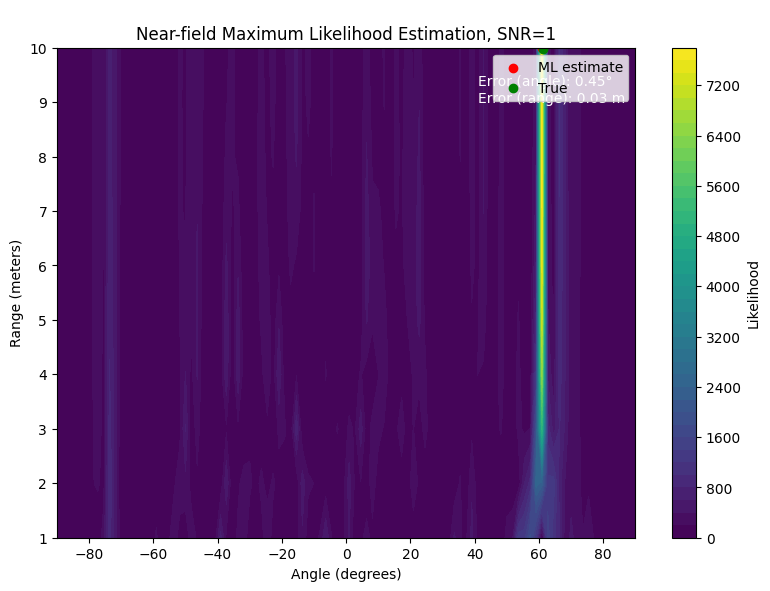


Estimated Near-field Angle of Arrival: 60.91 degrees
Estimated Near-field Range: 10.00 meters


In [163]:
r = np.random.uniform(range_limits[0], range_limits[1])
theta = np.random.uniform(-1,1)
snr = 1

################################
sigma_n = 1 / np.sqrt(snr)
s = CN_realization(mean=0, std_dev=1)
n = CN_realization(mean=0, std_dev=sigma_n, size=N)

print(f'theta = {np.rad2deg(np.arcsin(theta))}, theta = {theta}, r = {r}')

# uplink received signal
y_ = a(theta,r) * s + n
y = y_.reshape((N,1))
################################

ang_grid = np.linspace(-np.pi/2, np.pi/2, 100)  # Angle grid in radians
range_grid = np.linspace(range_limits[0], range_limits[1], 10)  # Range grid in meters

# Maximum Likelihood Estimation over angle and range for near-field
ML_bins_near = np.zeros((len(ang_grid), len(range_grid)), dtype=float)
for i, angg in enumerate(ang_grid):
    for j, rr in enumerate(range_grid):
        y1_test = a(np.sin(angg), rr) * s
        ML_bins_near[i, j] = np.abs(np.dot(y_, y1_test.conj().T))**2


# Find the indices of the maximum likelihood estimate for near-field
idx_ang_near, idx_range_near = np.unravel_index(np.argmax(ML_bins_near), ML_bins_near.shape)

# Display the results
plt.figure(figsize=(8, 6))

# Near-field plot
estimated_angle_near = np.degrees(ang_grid[idx_ang_near])
estimated_range_near = range_grid[idx_range_near]
rmse_angle = np.abs(estimated_angle_near - np.arcsin(theta)/np.pi*180)
rmse_range = np.abs(estimated_range_near - r)

# plt.subplot(1, 2, 2)
plt.contourf(np.degrees(ang_grid), range_grid, ML_bins_near.T, levels=50, cmap='viridis')
# plt.imshow(ML_bins_near.T, extent=[np.degrees(ang_grid).min(), np.degrees(ang_grid).max(), range_grid.min(), range_grid.max()], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Likelihood')
plt.scatter(np.degrees(ang_grid[idx_ang_near]), range_grid[idx_range_near], color='red', label='ML estimate')
plt.scatter(np.degrees(np.arcsin(theta)), r, color='green', label='True')
plt.xlabel('Angle (degrees)')
plt.ylabel('Range (meters)')
plt.title(f'Near-field Maximum Likelihood Estimation, SNR={snr}')
plt.text(np.degrees(ang_grid[idx_ang_near]) + 1, range_grid[idx_range_near] + 0.5,
         f"({estimated_angle_near:.2f}°, {estimated_range_near:.2f}m)", color='white', fontsize=10, ha='left')
plt.text(np.degrees(ang_grid[idx_ang_near]) - 20, range_grid[idx_range_near] - 1,
         f"Error (angle): {rmse_angle:.2f}°\nError (range): {rmse_range:.2f} m", color='white', fontsize=10, ha='left')
# plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
# plt.savefig(f'imgs/ML_estimate_r{r_true}_t{theta_true/np.pi*180}.png', dpi=300, bbox_inches='tight')

# Print the estimated angles and range
# estimated_angle_far = np.degrees(ang_grid[idx_ang_far])
estimated_angle_near = np.degrees(ang_grid[idx_ang_near])
estimated_range_near = range_grid[idx_range_near]
# print(f'Estimated Far-field Angle of Arrival: {estimated_angle_far:.2f} degrees')
print(f'\nEstimated Near-field Angle of Arrival: {estimated_angle_near:.2f} degrees')
print(f'Estimated Near-field Range: {estimated_range_near:.2f} meters')

## Plot all the results
The results of the DNN are based on the test set (10k samples)

In [122]:
model_path = 'saved_models/single_user/'
csv_filename = 'test_rmse.csv'
rmse_dnn_hyb_fully_RF16_rmax10m = pd.read_csv(model_path + 'fully-connected_epochs80_batch250_lr0.003_16RF_128N__r10/best_rmse_epoch.csv')
rmse_dnn_hyb_fully_RF16 = pd.read_csv(model_path + 'fully-connected_epochs80_batch250_lr0.001_16RF_128N_/' + csv_filename)
rmse_dnn_hyb_fully_RF8 = pd.read_csv(model_path + 'fully-connected_epochs80_batch250_lr0.001_8RF_128N_/' + csv_filename)
rmse_dnn_hyb_sub_RF16 = pd.read_csv(model_path + 'sub-connected_epochs200_batch250_lr0.001_16RF_128N_scheduler0150/' + csv_filename)
rmse_dnn_hyb_sub_RF8 = pd.read_csv(model_path + 'sub-connected_epochs200_batch250_lr0.001_8RF_128N_scheduler0150/' + csv_filename)

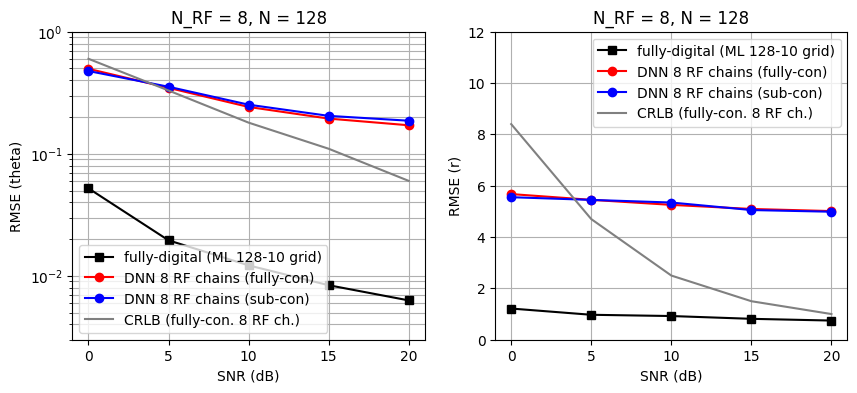

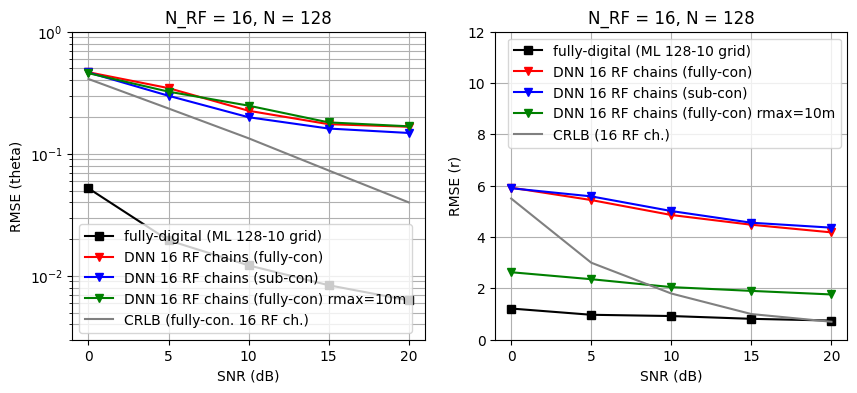

In [190]:
CRB_theta_8RF = [0.6, .33, .18, .11, .06]   # figure 3a
CRB_r_8RF = [8.4, 4.7, 2.5, 1.5, 1]         # figure 3b
CRB_theta_16RF = [.41, .235, .134, .073, .04] # figure 4a
CRB_r_16RF = [5.5, 3, 1.8, 1, 0.7]     # figure 4b


## 8 RF CHAINS
plt.figure(figsize=(10,4))
plt.subplot(122)
plt.title('N_RF = 8, N = 128')
plt.plot(SNR_dB, rmse_r_mean,'-sk',label=f'fully-digital (ML {N_ang}-{N_r} grid)')
# plt.plot(SNR_dB,rmse_dnn_hyb_fully_RF16_drop02['Test (r)'],'-xr',label='DNN 16 RF chains (fully-con) drop')
# plt.plot(SNR_dB,rmse_dnn_hyb_fully_RF16['Test (r)'],'-vr',label='DNN 16 RF chains (fully-con)')
# plt.plot(SNR_dB,rmse_dnn_hyb_sub_RF16['Test (r)'],'-vb',label='DNN 16 RF chains (sub-con)')
plt.plot(SNR_dB,rmse_dnn_hyb_fully_RF8['Test (r)'],'-or',label='DNN 8 RF chains (fully-con)')
plt.plot(SNR_dB,rmse_dnn_hyb_sub_RF8['Test (r)'],'-ob',label='DNN 8 RF chains (sub-con)')
plt.plot(SNR_dB,CRB_r_8RF,'-',label='CRLB (fully-con. 8 RF ch.)',color='grey')
# plt.plot(SNR_dB,CRB_r,'-or',label='CRLB fully-digital')
plt.xticks(SNR_dB)
# plt.ylim([4.4,6.2])
plt.ylim([0, 12])
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE (r)')
plt.legend()
plt.grid()

plt.subplot(121)
plt.title('N_RF = 8, N = 128')
plt.plot(SNR_dB, rmse_angle_rad_mean,'-sk',label=f'fully-digital (ML {N_ang}-{N_r} grid)')
# plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_fully_RF16_drop02['Test (theta)']/180*np.pi),'-xr',label='DNN 16 RF chains (fully-con) drop')
# plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_fully_RF16['Test (theta)']/180*np.pi),'-vr',label='DNN 16 RF chains (fully-con)')
# plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_sub_RF16['Test (theta)']/180*np.pi),'-vb',label='DNN 16 RF chains (sub-con)')
plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_fully_RF8['Test (theta)']/180*np.pi),'-or',label='DNN 8 RF chains (fully-con)')
plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_sub_RF8['Test (theta)']/180*np.pi),'-ob',label='DNN 8 RF chains (sub-con)')
plt.plot(SNR_dB,CRB_theta_8RF,'-',label='CRLB (fully-con. 8 RF ch.)',color='grey')
# plt.plot(SNR_dB,np.sin(CRB_theta),'-or',label='CRLB fully-digital')
plt.xticks(SNR_dB)
plt.yscale('log')
# plt.ylim([0.1,.6])
# plt.ylim([.04,1])
plt.ylim([.003,1])
plt.grid(True,which='both')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE (theta)')
plt.legend()

## 16 RF CHAINS
plt.figure(figsize=(10,4))
plt.subplot(122)
plt.title('N_RF = 16, N = 128')
plt.plot(SNR_dB, rmse_r_mean,'-sk',label=f'fully-digital (ML {N_ang}-{N_r} grid)')
# plt.plot(SNR_dB,rmse_dnn_hyb_fully_RF16_drop02['Test (r)'],'-xr',label='DNN 16 RF chains (fully-con) drop')
plt.plot(SNR_dB,rmse_dnn_hyb_fully_RF16['Test (r)'],'-vr',label='DNN 16 RF chains (fully-con)')
plt.plot(SNR_dB,rmse_dnn_hyb_sub_RF16['Test (r)'],'-vb',label='DNN 16 RF chains (sub-con)')
plt.plot(SNR_dB,rmse_dnn_hyb_fully_RF16_rmax10m['Val (r)'],'-vg',label='DNN 16 RF chains (fully-con) rmax=10m')
# plt.plot(SNR_dB,rmse_dnn_hyb_fully_RF8['Test (r)'],'-or',label='DNN 8 RF chains (fully-con)')
# plt.plot(SNR_dB,rmse_dnn_hyb_sub_RF8['Test (r)'],'-ob',label='DNN 8 RF chains (sub-con)')
plt.plot(SNR_dB,CRB_r_16RF,'-',label='CRLB (16 RF ch.)',color='grey')
# plt.plot(SNR_dB,CRB_r,'-or',label='CRLB fully-digital')
plt.xticks(SNR_dB)
# plt.ylim([4.4,6.2])
plt.ylim([0, 12])
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE (r)')
plt.legend()
plt.grid()

plt.subplot(121)
plt.title('N_RF = 16, N = 128')
plt.plot(SNR_dB, rmse_angle_rad_mean,'-sk',label=f'fully-digital (ML {N_ang}-{N_r} grid)')
# plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_fully_RF16_drop02['Test (theta)']/180*np.pi),'-xr',label='DNN 16 RF chains (fully-con) drop')
plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_fully_RF16['Test (theta)']/180*np.pi),'-vr',label='DNN 16 RF chains (fully-con)')
plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_sub_RF16['Test (theta)']/180*np.pi),'-vb',label='DNN 16 RF chains (sub-con)')
plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_fully_RF16_rmax10m['Val (theta)']/180*np.pi),'-vg',label='DNN 16 RF chains (fully-con) rmax=10m')
# plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_fully_RF8['Test (theta)']/180*np.pi),'-or',label='DNN 8 RF chains (fully-con)')
# plt.plot(SNR_dB,np.sin(rmse_dnn_hyb_sub_RF8['Test (theta)']/180*np.pi),'-ob',label='DNN 8 RF chains (sub-con)')
plt.plot(SNR_dB,CRB_theta_16RF,'-',label='CRLB (fully-con. 16 RF ch.)',color='grey')
# plt.plot(SNR_dB,np.sin(CRB_theta),'-or',label='CRLB fully-digital')
plt.xticks(SNR_dB)
plt.yscale('log')
# plt.ylim([0.1,.6])
plt.ylim([.003,1])
plt.grid(True,which='both')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE (theta)')
plt.legend()
plt.show()